In [34]:
import numpy as np
import pandas as pd
import pickle
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from linearmodels.panel import compare

import FixedEffectModelPyHDFE.api as FEM
from fixedeffect.fe import fixedeffect, did, getfe

from fixedeffect.fe import fixedeffect # for 3-way fixed https://pypi.org/project/FixedEffectModel/
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib

import seaborn as sns

matplotlib.rcParams['font.family'] = 'serif'

In [48]:
data_dir = '/home/simon/Documents/Bodies/data/done_dfs/'

with open(f'{data_dir}bodies_df_2022_v1_4.pkl', 'rb') as file:
    bodies_df = pickle.load(file)

In [49]:
# if you only want more robust observatino:

bodies_df = bodies_df[(bodies_df['distance_days'] <= 48) | (bodies_df['location_annot'] == 1)].copy() # only locations you are certain of
bodies_df = bodies_df[bodies_df['city'] != 'nan']

bodies_df = bodies_df[bodies_df['year'] >= 2003]
lwd = [294, 299, 300] # likely wrong dates/months. 
bodies_df = bodies_df[~bodies_df['month_id'].isin(lwd)].copy()


# indtil det er styr på det her:
bodies_df = bodies_df[bodies_df['publication'] != 'Published']

In [50]:
#bodies_df[['Published', 'Raw', 'Submitted']] = pd.get_dummies(bodies_df[['publication']])
bodies_df[['Raw', 'Submitted']] = pd.get_dummies(bodies_df[['publication']])

bodies_df.drop(columns= 'publication', inplace= True)

# for FE
bodies_df.set_index(['gid', 'month_id'], inplace = True)
#bodies_df.set_index(['city_id', 'month_id'], inplace = True)

In [44]:
# bodies_df = bodies_df[bodies_df['person_mean']>0]
# bodies_df['fem_ratio'] = bodies_df['female_mean'] / bodies_df['person_mean']

## As conflict intensifies we will see relatively less women overall

In [51]:
feature = ['log_best']

target =  'female_mean' #'uniformed_dummy'


X = bodies_df.loc[:,feature] 
X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model1 =  m.fit(cov_type='robust')

X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_entity=True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_entity=False, cluster_time = True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = True)


print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4}, precision = 'std_errors', stars = True))

                                    Model Comparison                                   
                                 model1          model2          model3          model4
---------------------------------------------------------------------------------------
Dep. Variable               female_mean     female_mean     female_mean     female_mean
Estimator                      PanelOLS        PanelOLS        PanelOLS        PanelOLS
No. Observations                 148717          148717          148717          148717
Cov. Est.                        Robust       Clustered       Clustered       Clustered
R-squared                        0.0015          0.0019       9.078e-05          0.0006
R-Squared (Within)               0.0017          0.0019         -0.0015         -0.0267
R-Squared (Between)             -0.0298          0.0245         -0.0102         -0.1115
R-Squared (Overall)              0.0015          0.0894         -0.0355         -0.3671
F-statistic                     

In [52]:

X = bodies_df.loc[:,['log_best']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, 'female_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model1 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'public_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'female_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'public_mean', 'rural_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'female_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'public_mean', 'rural_mean', 'nlights_calib_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'female_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'public_mean', 'rural_mean', 'nlights_calib_mean', 'Submitted']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'female_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'public_mean', 'rural_mean', 'nlights_calib_mean', 'Submitted', 'uniformed_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'female_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

                                                    Model Comparison                                                   
                                 model1          model2          model3          model4          model5          model6
-----------------------------------------------------------------------------------------------------------------------
Dep. Variable               female_mean     female_mean     female_mean     female_mean     female_mean     female_mean
Estimator                      PanelOLS        PanelOLS        PanelOLS        PanelOLS        PanelOLS        PanelOLS
No. Observations                 148717          148717          148717          148717          148717          148717
Cov. Est.                     Clustered       Clustered       Clustered       Clustered       Clustered       Clustered
R-squared                        0.0006          0.0104          0.1109          0.1111          0.1112          0.1147
R-Squared (Within)              -0.0267 

In [58]:
df_demean = bodies_df.copy()

df_demean['Mean_female_byPer'] = df_demean.groupby('person_mean').female_mean.transform(np.mean)
df_demean['Mean_log_best_byPer'] = df_demean.groupby('person_mean').log_best.transform(np.mean)
df_demean['Mean_public_byPer'] = df_demean.groupby('person_mean').public_mean.transform(np.mean)
df_demean['Mean_rural_byPer'] = df_demean.groupby('person_mean').rural_mean.transform(np.mean)
df_demean['Mean_nlights_byPer'] = df_demean.groupby('person_mean').nlights_calib_mean.transform(np.mean)
df_demean['Mean_submitted_byPer'] = df_demean.groupby('person_mean').Submitted.transform(np.mean)
df_demean['Mean_uniformed_byPer'] = df_demean.groupby('person_mean').uniformed_mean.transform(np.mean)


df_demean["female_demean"] = df_demean["female_mean"] - df_demean['Mean_female_byPer']
df_demean["log_best_demean"] = df_demean["log_best"] - df_demean['Mean_log_best_byPer']
df_demean["public_demean"] = df_demean["public_mean"] - df_demean['Mean_public_byPer']
df_demean["rural_demean"] = df_demean["rural_mean"] - df_demean['Mean_rural_byPer']
df_demean["nlights_demean"] = df_demean["nlights_calib_mean"] - df_demean['Mean_nlights_byPer']
df_demean["submitted_demean"] = df_demean["Submitted"] - df_demean['Mean_submitted_byPer']
df_demean["uniformed_demean"] = df_demean["uniformed_mean"] - df_demean['Mean_uniformed_byPer']



In [59]:
# PERSON FIXED EFFECTS

X = df_demean.loc[:,['log_best_demean']] 
#X = sm.add_constant(X)
y = df_demean.loc[:, 'female_demean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model1 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_demean.loc[:,[ 'log_best_demean', 'public_demean']] 
#X = sm.add_constant(X)

y = df_demean.loc[:, 'female_demean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_demean.loc[:,[ 'log_best_demean', 'public_demean', 'rural_demean']] 
#X = sm.add_constant(X)

y = df_demean.loc[:, 'female_demean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_demean.loc[:,[ 'log_best_demean', 'public_demean', 'rural_demean', 'nlights_demean']] 
#X = sm.add_constant(X)

y = df_demean.loc[:, 'female_demean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_demean.loc[:,[ 'log_best_demean', 'public_demean', 'rural_demean', 'nlights_demean', 'submitted_demean']] 
#X = sm.add_constant(X)

y = df_demean.loc[:, 'female_demean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_demean.loc[:,[ 'log_best_demean', 'public_demean', 'rural_demean', 'nlights_demean', 'submitted_demean', 'uniformed_demean']] 
#X = sm.add_constant(X)

y = df_demean.loc[:, 'female_demean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

                                                          Model Comparison                                                         
                                   model1            model2            model3            model4            model5            model6
-----------------------------------------------------------------------------------------------------------------------------------
Dep. Variable               female_demean     female_demean     female_demean     female_demean     female_demean     female_demean
Estimator                        PanelOLS          PanelOLS          PanelOLS          PanelOLS          PanelOLS          PanelOLS
No. Observations                   148717            148717            148717            148717            148717            148717
Cov. Est.                       Clustered         Clustered         Clustered         Clustered         Clustered         Clustered
R-squared                       7.687e-06            0.0637            0.106

# As conflict intensifies we will see relatively more women in religious garments

In [61]:
feature = ['log_best']

target =  'religiousGarmentFemale_mean' #'uniformed_dummy'


X = bodies_df.loc[:,feature] 
X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model1 =  m.fit(cov_type='robust')

X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_entity=True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_entity=False, cluster_time = True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = True)


print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4}, precision = 'std_errors', stars = True))

                                                                    Model Comparison                                                                   
                                                 model1                          model2                          model3                          model4
-------------------------------------------------------------------------------------------------------------------------------------------------------
Dep. Variable               religiousGarmentFemale_mean     religiousGarmentFemale_mean     religiousGarmentFemale_mean     religiousGarmentFemale_mean
Estimator                                      PanelOLS                        PanelOLS                        PanelOLS                        PanelOLS
No. Observations                                 148717                          148717                          148717                          148717
Cov. Est.                                        Robust                       Clustered 

In [63]:

X = bodies_df.loc[:,['log_best']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model1 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'public_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'public_mean', 'rural_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'public_mean', 'rural_mean', 'nlights_calib_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'public_mean', 'rural_mean', 'nlights_calib_mean', 'Submitted']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'public_mean', 'rural_mean', 'nlights_calib_mean', 'Submitted', 'uniformed_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

                                                                                                    Model Comparison                                                                                                   
                                                 model1                          model2                          model3                          model4                          model5                          model6
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dep. Variable               religiousGarmentFemale_mean     religiousGarmentFemale_mean     religiousGarmentFemale_mean     religiousGarmentFemale_mean     religiousGarmentFemale_mean     religiousGarmentFemale_mean
Estimator                                      PanelOLS                        PanelOLS                        PanelOLS                 

/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")


In [72]:
df_demean = bodies_df.copy()

df_demean['Mean_garments_byFem'] = df_demean.groupby('female_mean').religiousGarmentFemale_mean.transform(np.mean)
df_demean['Mean_log_best_byFem'] = df_demean.groupby('female_mean').log_best.transform(np.mean)
df_demean['Mean_public_byFem'] = df_demean.groupby('female_mean').public_mean.transform(np.mean)
df_demean['Mean_rural_byFem'] = df_demean.groupby('female_mean').rural_mean.transform(np.mean)
df_demean['Mean_nlights_byFem'] = df_demean.groupby('female_mean').nlights_calib_mean.transform(np.mean)
df_demean['Mean_submitted_byFem'] = df_demean.groupby('female_mean').Submitted.transform(np.mean)
df_demean['Mean_uniformed_byFem'] = df_demean.groupby('female_mean').uniformed_mean.transform(np.mean)


df_demean["garments_demean"] = df_demean["religiousGarmentFemale_mean"] - df_demean['Mean_garments_byFem']
df_demean["log_best_demean"] = df_demean["log_best"] - df_demean['Mean_log_best_byFem']
df_demean["public_demean"] = df_demean["public_mean"] - df_demean['Mean_public_byFem']
df_demean["rural_demean"] = df_demean["rural_mean"] - df_demean['Mean_rural_byFem']
df_demean["nlights_demean"] = df_demean["nlights_calib_mean"] - df_demean['Mean_nlights_byFem']
df_demean["submitted_demean"] = df_demean["Submitted"] - df_demean['Mean_submitted_byFem']
df_demean["uniformed_demean"] = df_demean["uniformed_mean"] - df_demean['Mean_uniformed_byFem']



In [73]:
# FEMALE FIXED EFFECTS

X = df_demean.loc[:,['log_best_demean']] 
#X = sm.add_constant(X)
y = df_demean.loc[:, 'garments_demean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model1 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_demean.loc[:,[ 'log_best_demean', 'public_demean']] 
#X = sm.add_constant(X)

y = df_demean.loc[:, 'garments_demean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_demean.loc[:,[ 'log_best_demean', 'public_demean', 'rural_demean']] 
#X = sm.add_constant(X)

y = df_demean.loc[:, 'garments_demean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_demean.loc[:,[ 'log_best_demean', 'public_demean', 'rural_demean', 'nlights_demean']] 
#X = sm.add_constant(X)

y = df_demean.loc[:, 'garments_demean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_demean.loc[:,[ 'log_best_demean', 'public_demean', 'rural_demean', 'nlights_demean', 'submitted_demean']] 
#X = sm.add_constant(X)

y = df_demean.loc[:, 'garments_demean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_demean.loc[:,[ 'log_best_demean', 'public_demean', 'rural_demean', 'nlights_demean', 'submitted_demean', 'uniformed_demean']] 
#X = sm.add_constant(X)

y = df_demean.loc[:, 'garments_demean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

                                                                Model Comparison                                                               
                                     model1              model2              model3              model4              model5              model6
-----------------------------------------------------------------------------------------------------------------------------------------------
Dep. Variable               garments_demean     garments_demean     garments_demean     garments_demean     garments_demean     garments_demean
Estimator                          PanelOLS            PanelOLS            PanelOLS            PanelOLS            PanelOLS            PanelOLS
No. Observations                     148717              148717              148717              148717              148717              148717
Cov. Est.                         Clustered           Clustered           Clustered           Clustered           Clustered           Cl

# The decreased presence of women will be more prevailing in public scenes
# The decreased presence of women will be less prevailing in private scenes

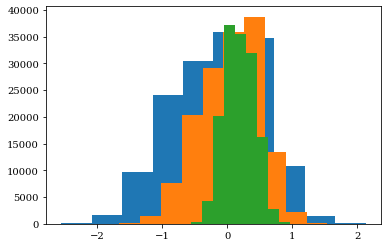

In [87]:
plt.hist(bodies_df['pp'])
plt.hist(bodies_df['public_mean'])
plt.hist(bodies_df['privat_mean'])

plt.show()

In [91]:
bodies_df['female_dummy'] = (bodies_df['female_mean'] > 0)*1
bodies_df['pp'] = bodies_df['public_mean'] - bodies_df['privat_mean']

# public_df = bodies_df[bodies_df['public_mean']>0]
# privat_df = bodies_df[bodies_df['public_mean']<0]

# bodies_df['log_best_public'] = bodies_df['log_best'] * bodies_df['public_mean']


public_df = bodies_df[bodies_df['pp']>0]
privat_df = bodies_df[bodies_df['pp']<0]

bodies_df['log_best_public'] = bodies_df['log_best'] * bodies_df['pp']

In [93]:
# But why not person fixed effects?
# And why not subset the df to person > 0 as below

X = public_df.loc[:,['log_best', 'person_mean']] 
#X = sm.add_constant(X)
y = public_df.loc[:, 'female_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model1 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = privat_df.loc[:,[ 'log_best', 'person_mean']] 
#X = sm.add_constant(X)

y = privat_df.loc[:, 'female_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'public_mean', 'log_best_public', 'person_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'female_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)



print(compare({"model1": model1, "model2": model2, "model3": model3}, precision = 'std_errors', stars = True))

                            Model Comparison                           
                                 model1          model2          model3
-----------------------------------------------------------------------
Dep. Variable               female_mean     female_mean     female_mean
Estimator                      PanelOLS        PanelOLS        PanelOLS
No. Observations                  67358           81359          148717
Cov. Est.                     Clustered       Clustered       Clustered
R-squared                        0.3441          0.3548          0.3604
R-Squared (Within)               0.3478          0.3533          0.3635
R-Squared (Between)              0.6599          0.8622          0.7411
R-Squared (Overall)              0.4475          0.5622          0.5493
F-statistic                   1.766e+04       2.236e+04       2.094e+04
P-value (F-stat)                 0.0000          0.0000          0.0000
=====================     =============   =============   ======

In [92]:

X = public_df.loc[:,['log_best']] 
#X = sm.add_constant(X)
y = public_df.loc[:, 'female_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model1 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = privat_df.loc[:,[ 'log_best']] 
#X = sm.add_constant(X)

y = privat_df.loc[:, 'female_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'public_mean', 'log_best_public']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'female_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)



print(compare({"model1": model1, "model2": model2, "model3": model3}, precision = 'std_errors', stars = True))

                             Model Comparison                             
                                  model1           model2           model3
--------------------------------------------------------------------------
Dep. Variable               female_dummy     female_dummy     female_dummy
Estimator                       PanelOLS         PanelOLS         PanelOLS
No. Observations                   67358            81359           148717
Cov. Est.                      Clustered        Clustered        Clustered
R-squared                         0.0028         1.23e-06           0.0334
R-Squared (Within)               -0.0714          -0.0010           0.0084
R-Squared (Between)              -0.3455          -0.0070          -0.1231
R-Squared (Overall)              -0.9220          -0.0170          -0.2822
F-statistic                       189.16           0.1000           1714.2
P-value (F-stat)                  0.0000           0.7518           0.0000
=====================    

# The women who does appear in public spaces are more likely to where religious garments

In [96]:
bodies_df['garment_dummy'] = (bodies_df['religiousGarmentFemale_mean'] > 0)*1
bodies_df['pp'] = bodies_df['public_mean'] - bodies_df['privat_mean']

public_df = bodies_df[(bodies_df['pp']>0)&(bodies_df['person_mean']>0)]
privat_df = bodies_df[(bodies_df['pp']<0)&(bodies_df['person_mean']>0)]

bodies_df['log_best_public'] = bodies_df['log_best'] * bodies_df['pp']

In [98]:
# FEMALE FIXED EFFECTS

X = public_df.loc[:,['log_best', 'female_mean']] 
#X = sm.add_constant(X)
y = public_df.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model1 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = privat_df.loc[:,[ 'log_best', 'female_mean']] 
#X = sm.add_constant(X)

y = privat_df.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'public_mean', 'log_best_public', 'female_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)



print(compare({"model1": model1, "model2": model2, "model3": model3}, precision = 'std_errors', stars = True))

                                                    Model Comparison                                                   
                                                 model1                          model2                          model3
-----------------------------------------------------------------------------------------------------------------------
Dep. Variable               religiousGarmentFemale_mean     religiousGarmentFemale_mean     religiousGarmentFemale_mean
Estimator                                      PanelOLS                        PanelOLS                        PanelOLS
No. Observations                                  55950                           67876                          148717
Cov. Est.                                     Clustered                       Clustered                       Clustered
R-squared                                        0.4052                          0.2705                          0.3533
R-Squared (Within)                      

In [99]:

X = public_df.loc[:,['log_best', 'female_mean']] 
#X = sm.add_constant(X)
y = public_df.loc[:, 'garment_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model1 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = privat_df.loc[:,[ 'log_best', 'female_mean']] 
#X = sm.add_constant(X)

y = privat_df.loc[:, 'garment_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'public_mean', 'log_best_public', 'female_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'garment_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)



print(compare({"model1": model1, "model2": model2, "model3": model3}, precision = 'std_errors', stars = True))

/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")


                               Model Comparison                              
                                   model1            model2            model3
-----------------------------------------------------------------------------
Dep. Variable               garment_dummy     garment_dummy     garment_dummy
Estimator                        PanelOLS          PanelOLS          PanelOLS
No. Observations                    55950             67876            148717
Cov. Est.                       Clustered         Clustered         Clustered
R-squared                          0.2927            0.2089            0.2730
R-Squared (Within)                 0.3185            0.2202            0.2880
R-Squared (Between)                0.8633            0.9141            0.8946
R-Squared (Overall)                0.4277            0.3915            0.4095
F-statistic                     1.157e+04            8953.6         1.396e+04
P-value (F-stat)                   0.0000            0.0000     

/home/simon/anaconda3/envs/scikit_env/lib/python3.8/site-packages/linearmodels/panel/results.py:87: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")


### THE LAST ONE BUT WITH FEMALE FE

In [100]:

df_demean_pub = public_df.copy()
df_demean_pri = privat_df.copy()
df_demean = bodies_df.copy() 

df_demean_pub['Mean_garments_byFem'] = df_demean_pub.groupby('female_mean').religiousGarmentFemale_mean.transform(np.mean)
df_demean_pri['Mean_garments_byFem'] = df_demean_pri.groupby('female_mean').religiousGarmentFemale_mean.transform(np.mean)
df_demean['Mean_garments_byFem'] = df_demean.groupby('female_mean').religiousGarmentFemale_mean.transform(np.mean)

df_demean_pub['Mean_log_best_byFem'] = df_demean_pub.groupby('female_mean').log_best.transform(np.mean)
df_demean_pri['Mean_log_best_byFem']  = df_demean_pri.groupby('female_mean').log_best.transform(np.mean)
df_demean['Mean_log_best_byFem']  = df_demean.groupby('female_mean').log_best.transform(np.mean)

df_demean_pub['Mean_public_byFem'] = df_demean_pub.groupby('female_mean').public_mean.transform(np.mean)
df_demean_pri['Mean_public_byFem'] = df_demean_pri.groupby('female_mean').public_mean.transform(np.mean)
df_demean['Mean_public_byFem'] = df_demean.groupby('female_mean').public_mean.transform(np.mean)

df_demean_pub['Mena_lbp_byFem'] = df_demean_pub.groupby('female_mean').log_best_public.transform(np.mean)
df_demean_pri['Mena_lbp_byFem'] = df_demean_pri.groupby('female_mean').log_best_public.transform(np.mean)
df_demean['Mena_lbp_byFem'] = df_demean.groupby('female_mean').log_best_public.transform(np.mean)

# ----------------------------------------------------------------------------------------

df_demean_pub['garments_demean'] = df_demean_pub["religiousGarmentFemale_mean"] - df_demean_pub['Mean_garments_byFem']
df_demean_pri['garments_demean'] =  df_demean_pri["religiousGarmentFemale_mean"] - df_demean_pri['Mean_garments_byFem']
df_demean['garments_demean'] =  df_demean["religiousGarmentFemale_mean"] - df_demean['Mean_garments_byFem']

df_demean_pub['log_best_demean']  = df_demean_pub["log_best"] - df_demean_pub['Mean_log_best_byFem']
df_demean_pri['log_best_demean'] = df_demean_pri["log_best"] - df_demean_pri['Mean_log_best_byFem']
df_demean['log_best_demean'] = df_demean["log_best"] - df_demean['Mean_log_best_byFem']

df_demean_pub['public_demean'] = df_demean_pub["public_mean"] - df_demean_pub['Mean_public_byFem']
df_demean_pri['public_demean'] = df_demean_pri["public_mean"] - df_demean_pri['Mean_public_byFem']
df_demean['public_demean'] = df_demean["public_mean"] - df_demean['Mean_public_byFem']

df_demean_pub['lbp_demean'] = df_demean_pub["log_best_public"] - df_demean_pub['Mena_lbp_byFem']
df_demean_pri['lbp_demean'] = df_demean_pri["log_best_public"] - df_demean_pri['Mena_lbp_byFem']
df_demean['lbp_demean'] = df_demean["log_best_public"] - df_demean['Mena_lbp_byFem']

In [ ]:

df_demean["garments_demean"] = df_demean["religiousGarmentFemale_mean"] - df_demean['Mean_garments_byFem']
df_demean["log_best_demean"] = df_demean["log_best"] - df_demean['Mean_log_best_byFem']
df_demean["public_demean"] = df_demean["public_mean"] - df_demean['Mean_public_byFem']
df_demean["rural_demean"] = df_demean["rural_mean"] - df_demean['Mean_rural_byFem']
df_demean["nlights_demean"] = df_demean["nlights_calib_mean"] - df_demean['Mean_nlights_byFem']
df_demean["submitted_demean"] = df_demean["Submitted"] - df_demean['Mean_submitted_byFem']
df_demean["uniformed_demean"] = df_demean["uniformed_mean"] - df_demean['Mean_uniformed_byFem']


In [101]:
# FEMALE FIXED EFFECTS

X = public_df.loc[:,['log_best', 'female_mean']] 
#X = sm.add_constant(X)
y = public_df.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model1 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = privat_df.loc[:,[ 'log_best', 'female_mean']] 
#X = sm.add_constant(X)

y = privat_df.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'public_mean', 'log_best_public', 'female_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)



print(compare({"model1": model1, "model2": model2, "model3": model3}, precision = 'std_errors', stars = True))

                                                    Model Comparison                                                   
                                                 model1                          model2                          model3
-----------------------------------------------------------------------------------------------------------------------
Dep. Variable               religiousGarmentFemale_mean     religiousGarmentFemale_mean     religiousGarmentFemale_mean
Estimator                                      PanelOLS                        PanelOLS                        PanelOLS
No. Observations                                  55950                           67876                          148717
Cov. Est.                                     Clustered                       Clustered                       Clustered
R-squared                                        0.4052                          0.2705                          0.3533
R-Squared (Within)                      